In [33]:
# backend.py

from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool
from dotenv import load_dotenv
import sqlite3
import requests
import os
load_dotenv()

True

In [34]:
# -------------------
# 1. LLM
# -------------------
llm = ChatGoogleGenerativeAI(model = 'gemini-2.5-flash')

In [36]:
# 2. Tools
# -------------------
# Tools
search_tool = DuckDuckGoSearchRun(region="us-en")
@tool
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    """
    Perform a basic arithmetic operation on two numbers.
    Supported operations: add, sub, mul, div
    """
    try:
        if operation == "add":
            result = first_num + second_num
        elif operation == "sub":
            result = first_num - second_num
        elif operation == "mul":
            result = first_num * second_num
        elif operation == "div":
            if second_num == 0:
                return {"error": "Division by zero is not allowed"}
            result = first_num / second_num
        else:
            return {"error": f"Unsupported operation '{operation}'"}
        
        return {"first_num": first_num, "second_num": second_num, "operation": operation, "result": result}
    except Exception as e:
        return {"error": str(e)}
    
@tool
def get_stock_price(symbol: str) -> dict:
    """
    Fetch latest stock price for a given symbol (e.g. 'AAPL', 'TSLA') 
    using Alpha Vantage with API key in the URL.
    """
    url = f"https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey=C9PE94QUEW9VWGFM"
    r = requests.get(url)
    return r.json()

@tool
def get_weather_data(city: str) -> str:
    """
    This function fetches the current weather data for a given city
    """
    WEATHER_STACK_API = os.environ.get('WEATHER_STACK_API')
    url = f'https://api.weatherstack.com/current?access_key={WEATHER_STACK_API}&query={city}'
    response = requests.get(url)
    return response.json()

In [ ]:
# get_weather_data('chennai')

{'request': {'type': 'City',
  'query': 'Chennai, India',
  'language': 'en',
  'unit': 'm'},
 'location': {'name': 'Chennai',
  'country': 'India',
  'region': 'Tamil Nadu',
  'lat': '13.083',
  'lon': '80.283',
  'timezone_id': 'Asia/Kolkata',
  'localtime': '2025-11-06 22:39',
  'localtime_epoch': 1762468740,
  'utc_offset': '5.50'},
 'current': {'observation_time': '05:09 PM',
  'temperature': 26,
  'weather_code': 143,
  'weather_icons': ['https://cdn.worldweatheronline.com/images/wsymbols01_png_64/wsymbol_0006_mist.png'],
  'weather_descriptions': ['Mist'],
  'astro': {'sunrise': '06:04 AM',
   'sunset': '05:41 PM',
   'moonrise': '06:21 PM',
   'moonset': '06:37 AM',
   'moon_phase': 'Waning Gibbous',
   'moon_illumination': 100},
  'air_quality': {'co': '445.85',
   'no2': '10.85',
   'o3': '122',
   'so2': '5.25',
   'pm2_5': '19.35',
   'pm10': '19.95',
   'us-epa-index': '2',
   'gb-defra-index': '2'},
  'wind_speed': 11,
  'wind_degree': 72,
  'wind_dir': 'ENE',
  'pressure

In [37]:
tools = [search_tool, get_stock_price, calculator,get_weather_data]
llm_with_tools = llm.bind_tools(tools)


In [38]:
# -------------------
# 3. State
# -------------------
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [39]:
# -------------------
# 4. Nodes
# -------------------
def chat_node(state: ChatState):
    """LLM node that may answer or request a tool call."""
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

tool_node = ToolNode(tools)

In [40]:
# -------------------
# 5. Checkpointer
# -------------------
conn = sqlite3.connect(database="test_chatbot.db", check_same_thread=False)
checkpointer = SqliteSaver(conn=conn)

In [41]:
# -------------------
# 6. Graph
# -------------------
graph = StateGraph(ChatState)
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

graph.add_edge(START, "chat_node")

graph.add_conditional_edges("chat_node",tools_condition)
graph.add_edge('tools', 'chat_node')

chatbot = graph.compile(checkpointer=checkpointer)

In [42]:
# -------------------
# 7. Helper
# -------------------
def retrieve_all_threads():
    all_threads = set()
    for checkpoint in checkpointer.list(None):
        all_threads.add(checkpoint.config["configurable"]["thread_id"])
    return list(all_threads)

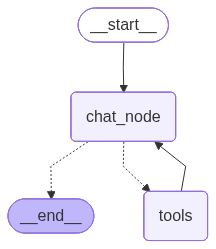

In [43]:
chatbot

In [44]:
CONFIG = {'configurable': {'thread_id': 'thread-1'}}

In [52]:
user_input = 'capital city of maharastra and what is current temparature of it , what is the sum of 5,3'

In [53]:
chatbot.invoke({'messages': [HumanMessage(content=user_input)]}, config=CONFIG)

{'messages': [HumanMessage(content='what is the capital of india and what is hte current temparature of it', additional_kwargs={}, response_metadata={}, id='08ad48a3-685b-4b67-893d-ea28e17d9e01'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'duckduckgo_search', 'arguments': '{"query": "capital of india"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--ce4466b1-a261-4f8e-8f35-5770e68647f7-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'capital of india'}, 'id': 'eb17040c-ccb2-4fc2-be55-fb8726c072e9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 276, 'output_tokens': 153, 'total_tokens': 429, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 134}}),
  ToolMessage(content='Delhi,[b] officially the National Capital Territ